# 05 — Training Monitor Dashboard

Extract and visualize all training metrics from `trainer_state.json` across checkpoints.

**Metrics:**
- Training Loss (smoothed)
- Gradient Norm (stability)
- Learning Rate (schedule)
- Loss improvement rate
- Convergence detection

In [19]:
# Cell 1: Imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Cell 2: Config & Load Data
project_root = Path('..').resolve()
outputs_dir = project_root / 'outputs'

# You can change this to 'dora_runs' or 'good-enough' to compare different runs
run_name = 'lora_runs'
run_path = outputs_dir / run_name

print(f"📁 Loading from: {run_path}")
print(f"Available runs: {[d.name for d in outputs_dir.iterdir() if d.is_dir()]}")

📁 Loading from: C:\Users\a\Desktop\other SHIET\fine-poems\outputs\lora_runs
Available runs: ['good-enough', 'lora_runs']


In [21]:
# Cell 3: Load metrics from latest checkpoint
def extract_training_metrics(run_path):
    """
    Load log_history from latest checkpoint's trainer_state.json.
    Latest checkpoint contains all prior training steps.
    """
    checkpoints = sorted([d for d in run_path.iterdir() if d.is_dir() and d.name.startswith('checkpoint-')])
    
    if not checkpoints:
        raise ValueError(f"No checkpoints found in {run_path}")
    
    # Use only the latest checkpoint
    latest_checkpoint = checkpoints[-1]
    state_file = latest_checkpoint / 'trainer_state.json'
    
    with open(state_file, 'r') as f:
        state = json.load(f)
    
    # Create DataFrame from log_history
    df = pd.DataFrame(state.get('log_history', []))
    
    # Keep only rows with 'step' and 'loss' (skip validation-only rows)
    df = df[df['step'].notna() & df['loss'].notna()].drop_duplicates(subset=['step']).reset_index(drop=True)
    df = df.sort_values('step').reset_index(drop=True)
    
    return df

metrics_df = extract_training_metrics(run_path)
print(f"\n✅ Extracted {len(metrics_df)} training steps")
print(f"\nMetrics available: {list(metrics_df.columns)}")
print(f"\nData preview:")
print(metrics_df.head(10))


✅ Extracted 797 training steps

Metrics available: ['epoch', 'grad_norm', 'learning_rate', 'loss', 'step']

Data preview:
      epoch  grad_norm  learning_rate    loss  step
0  0.001254   2.977828       0.000002  3.6058     5
1  0.002509   4.121765       0.000005  3.9359    10
2  0.003763   3.596303       0.000007  3.6852    15
3  0.005018   3.405373       0.000010  3.6854    20
4  0.006272   1.981956       0.000012  3.5422    25
5  0.007527   2.055707       0.000015  3.1301    30
6  0.008781   2.639984       0.000017  2.8855    35
7  0.010036   2.716599       0.000020  2.6694    40
8  0.011290   2.114454       0.000022  2.3742    45
9  0.012545   1.992550       0.000025  2.1769    50


In [22]:
# Cell 4: Compute derived metrics
# Loss improvement per step
metrics_df['loss_delta'] = metrics_df['loss'].diff()
metrics_df['loss_delta_pct'] = (metrics_df['loss'].pct_change() * 100)

# Smoothed loss (for trend detection)
metrics_df['loss_smoothed'] = gaussian_filter1d(metrics_df['loss'], sigma=10)

# Learning rate in scientific notation
metrics_df['lr_magnitude'] = -np.log10(metrics_df['learning_rate'])

print("✓ Derived metrics computed")
print(f"\nComputed columns: loss_delta, loss_delta_pct, loss_smoothed, lr_magnitude")

✓ Derived metrics computed

Computed columns: loss_delta, loss_delta_pct, loss_smoothed, lr_magnitude


In [23]:
# Cell 5: Summary Statistics
print("\n" + "="*60)
print("📊 TRAINING SUMMARY")
print("="*60)

metrics = {
    'Total Steps': int(metrics_df['step'].max()),
    'Initial Loss': f"{metrics_df['loss'].iloc[0]:.4f}",
    'Final Loss': f"{metrics_df['loss'].iloc[-1]:.4f}",
    'Min Loss': f"{metrics_df['loss'].min():.4f} @ Step {int(metrics_df.loc[metrics_df['loss'].idxmin(), 'step'])}",
    'Max Loss': f"{metrics_df['loss'].max():.4f}",
    'Loss Improvement': f"{(metrics_df['loss'].iloc[0] - metrics_df['loss'].iloc[-1]):.4f} ({(1 - metrics_df['loss'].iloc[-1]/metrics_df['loss'].iloc[0])*100:.1f}%)",
}

for key, val in metrics.items():
    print(f"  {key:<25} {val}")

# Gradient norm stats
if 'grad_norm' in metrics_df.columns:
    print(f"\n  Gradient Norm (avg)      {metrics_df['grad_norm'].mean():.4f}")
    print(f"  Gradient Norm (max)      {metrics_df['grad_norm'].max():.4f}")
    print(f"  Exploding Gradients?     {'⚠️  YES (>100)' if metrics_df['grad_norm'].max() > 100 else '✓ No'}")

print("\n" + "="*60)


📊 TRAINING SUMMARY
  Total Steps               3985
  Initial Loss              3.6058
  Final Loss                1.2923
  Min Loss                  1.2376 @ Step 3560
  Max Loss                  3.9359
  Loss Improvement          2.3135 (64.2%)

  Gradient Norm (avg)      1.9618
  Gradient Norm (max)      26.4156
  Exploding Gradients?     ✓ No



In [24]:
# Cell 6: Learning Rate Schedule
print("\n📈 LEARNING RATE\n")

lr_at_end = metrics_df['learning_rate'].iloc[-1]
lr_at_start = metrics_df['learning_rate'].iloc[0]

print(f"  Initial LR:              {lr_at_start:.2e}")
print(f"  Final LR:                {lr_at_end:.2e}")
print(f"  Total Decay:             {(1 - lr_at_end/lr_at_start)*100:.1f}%")


📈 LEARNING RATE

  Initial LR:              2.01e-06
  Final LR:                1.12e-07
  Total Decay:             94.4%


In [25]:
# Cell 7: Detection - Convergence & Plateau
print("\n🎯 CONVERGENCE ANALYSIS\n")

# Last 10% of training
last_n = max(100, len(metrics_df) // 10)
last_segment = metrics_df.iloc[-last_n:]

# Slope of loss in final segment
x_last = np.array(last_segment['step'].values - last_segment['step'].values[0])
y_last = np.array(last_segment['loss'].values)
slope, intercept, r_value, p_value, std_err = linregress(x_last, y_last)

print(f"  Last {last_n} steps (final {(last_n/len(metrics_df)*100):.1f}% of training):")
print(f"    - Loss slope:          {slope:.2e} per step")
print(f"    - Avg loss:            {y_last.mean():.4f}")
print(f"    - Std of loss:         {y_last.std():.4f}")
print(f"    - R²:                  {r_value**2:.4f} (fit quality)")

if abs(slope) < 0.0001:
    print(f"\n  ✓ Model has CONVERGED (loss plateau detected)")
else:
    print(f"\n  ⚠️  Model still improving (slope = {slope:.2e})")


🎯 CONVERGENCE ANALYSIS

  Last 100 steps (final 12.5% of training):
    - Loss slope:          -9.44e-05 per step
    - Avg loss:            1.3422
    - Std of loss:         0.0486
    - R²:                  0.0785 (fit quality)

  ✓ Model has CONVERGED (loss plateau detected)


✓ Dashboard saved to training_metrics_dashboard.png


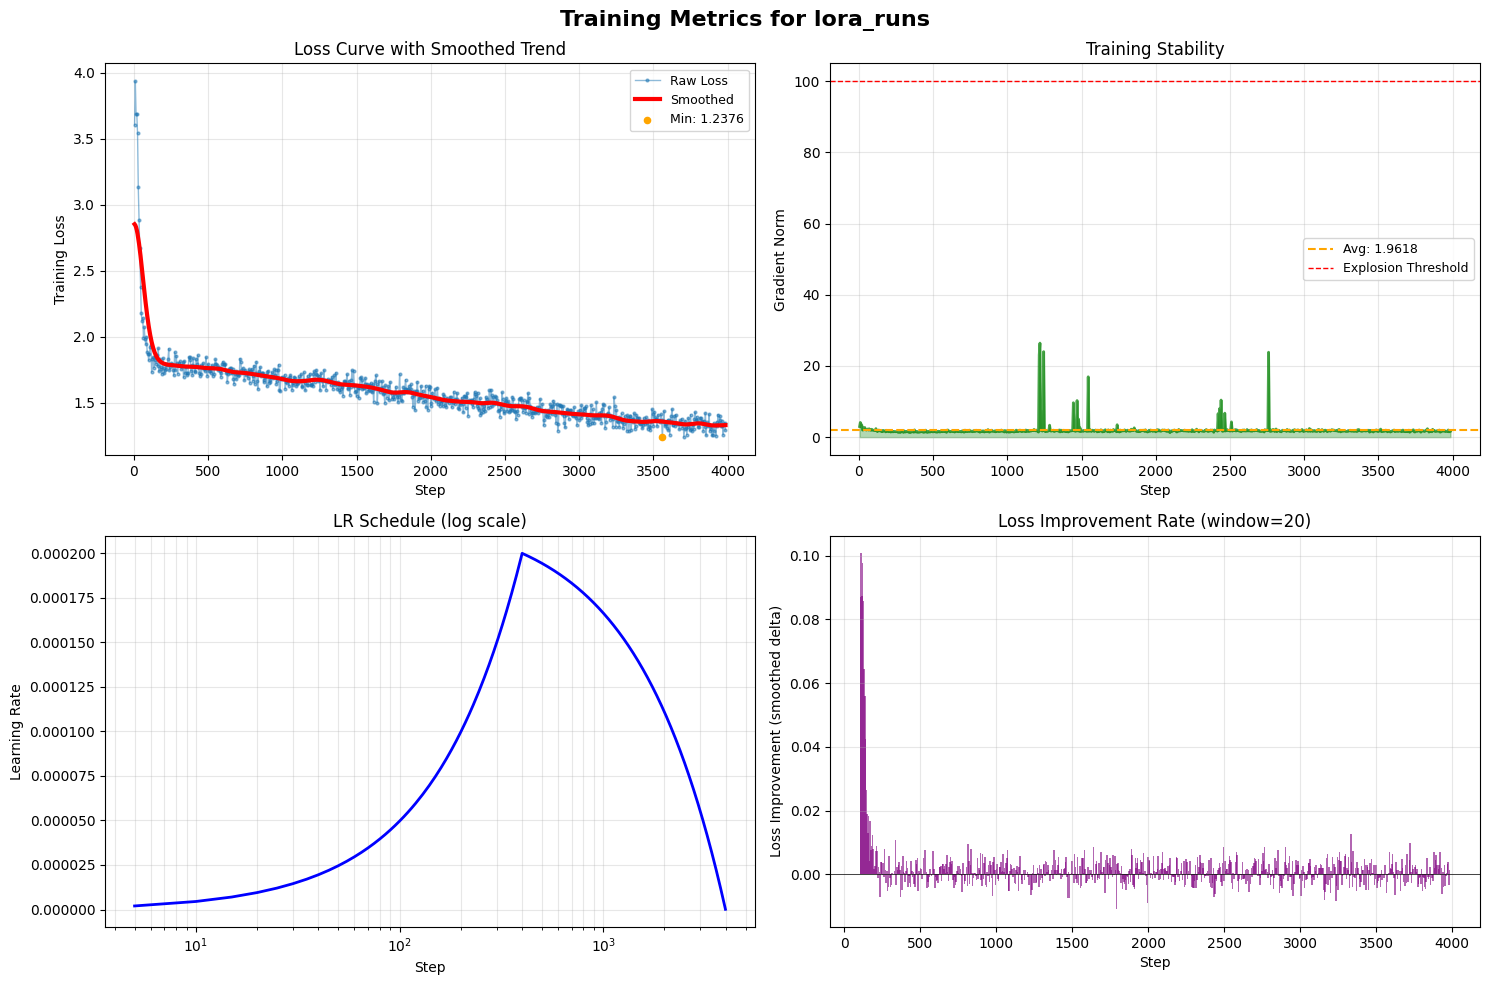

In [26]:
# Cell 8: Multi-metric Visualization (4-panel grid)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Training Metrics for {run_name}', fontsize=16, fontweight='bold')

# Panel 1: Loss + Smoothed
ax = axes[0, 0]
ax.plot(metrics_df['step'], metrics_df['loss'], 'o-', linewidth=1, markersize=2, alpha=0.5, label='Raw Loss')
ax.plot(metrics_df['step'], metrics_df['loss_smoothed'], linewidth=3, color='red', label='Smoothed')
min_idx = metrics_df['loss'].idxmin()
ax.scatter(metrics_df.loc[min_idx, 'step'], metrics_df.loc[min_idx, 'loss'], 
          color='orange', s=20, zorder=5, label=f'Min: {metrics_df.loc[min_idx, "loss"]:.4f}')
ax.set_xlabel('Step')
ax.set_ylabel('Training Loss')
ax.set_title('Loss Curve with Smoothed Trend')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Gradient Norm
ax = axes[0, 1]
if 'grad_norm' in metrics_df.columns:
    ax.plot(metrics_df['step'], metrics_df['grad_norm'], 'g-', linewidth=2, alpha=0.7)
    ax.fill_between(metrics_df['step'], metrics_df['grad_norm'], alpha=0.3, color='green')
    ax.axhline(y=metrics_df['grad_norm'].mean(), color='orange', linestyle='--', 
               label=f'Avg: {metrics_df["grad_norm"].mean():.4f}')
    ax.axhline(y=100, color='red', linestyle='--', linewidth=1, label='Explosion Threshold')
    ax.set_ylabel('Gradient Norm')
    ax.set_title('Training Stability')
    ax.legend(fontsize=9)
else:
    ax.text(0.5, 0.5, 'No gradient norm data', ha='center', va='center')
    ax.set_title('Gradient Norm (N/A)')
ax.set_xlabel('Step')
ax.grid(True, alpha=0.3)

# Panel 3: Learning Rate Schedule
ax = axes[1, 0]
ax.semilogx(metrics_df['step'], metrics_df['learning_rate'], 'b-', linewidth=2)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('LR Schedule (log scale)')
ax.grid(True, alpha=0.3, which='both')

# Panel 4: Loss Improvement Rate
ax = axes[1, 1]
# Use percentage change with smoothing
window = 20
loss_improvement = -metrics_df['loss_delta'].rolling(window=window).mean()
ax.bar(metrics_df['step'], loss_improvement, width=10, alpha=0.6, color='purple')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Loss Improvement (smoothed delta)')
ax.set_title(f'Loss Improvement Rate (window={window})')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'training_metrics_dashboard.png', dpi=450, bbox_inches='tight')
print("✓ Dashboard saved to training_metrics_dashboard.png")
plt.show()

In [27]:
# Cell 9: Comparative Analysis (if multiple runs exist)
def compare_runs(outputs_dir, run_names=['lora_runs', 'dora_runs']):
    """
    Compare multiple training runs side-by-side.
    """
    fig, axes = plt.subplots(1, len(run_names), figsize=(5*len(run_names), 5))
    
    if len(run_names) == 1:
        axes = [axes]  # Handle single subplot case
    
    for idx, run_name in enumerate(run_names):
        run_path = outputs_dir / run_name
        
        if not run_path.exists():
            axes[idx].text(0.5, 0.5, f'{run_name}\n(not found)', ha='center', va='center')
            axes[idx].set_title(run_name)
            continue
        
        df = extract_training_metrics(run_path)
        df['loss_smoothed'] = gaussian_filter1d(df['loss'], sigma=10)
        
        ax = axes[idx]
        ax.plot(df['step'], df['loss'], 'o-', linewidth=1, markersize=2, alpha=0.5)
        ax.plot(df['step'], df['loss_smoothed'], linewidth=3, color='red')
        ax.set_xlabel('Step')
        ax.set_ylabel('Training Loss')
        ax.set_title(f"{run_name}\nFinal: {df['loss'].iloc[-1]:.4f}")
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(outputs_dir / 'comparison_runs.png', dpi=150, bbox_inches='tight')
    print("✓ Comparison saved to comparison_runs.png")
    plt.show()

# Uncomment to compare LoRA vs DoRA:
# compare_runs(outputs_dir, run_names=['lora_runs', 'dora_runs'])